In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from pyampd import ampd
import scipy.signal as signal
import scipy.ndimage as ndimage
from scipy.signal import ShortTimeFFT, windows


def db(x):
    return 10 * np.log10(x)
    

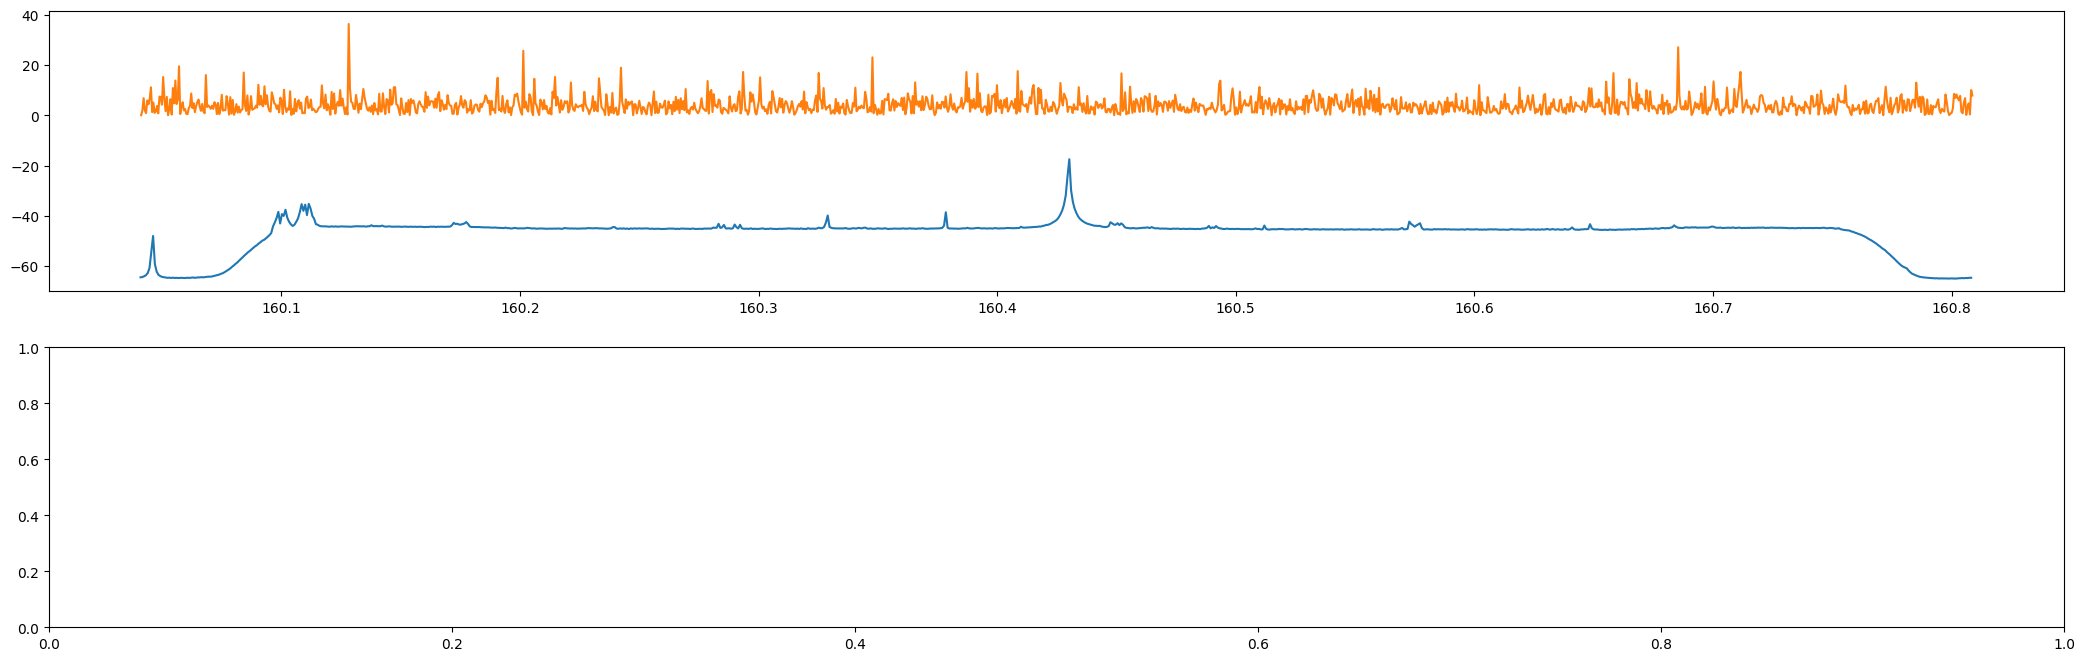

In [103]:
# load raw samples
d = np.fromfile("../data/test_windows.fc32", dtype=np.complex64)
samples = d[512000:768000]
fs = 768_000  # sampling frequency
f0  = 160425000
N_fft = 1024

# Generate array of channel frequencies
f = (np.fft.fftshift(np.fft.fftfreq(N_fft, 1/fs)) + f0) / 1e6

# Time tag each sample
t = np.arange(len(d)) / fs

# Reshape so we can do an FFT over an axis
d_fft = d.reshape((-1, N_fft))
D = np.fft.fftshift(np.fft.fft(d_fft, axis=1), axes=(1,))

# Time tag each sample coming from a channel
T = np.arange(len(D)) / fs * N_fft

# Now convert into power spectral density
# 1. Reshape to (N_timestep, N_int_per_timestep, N_fft)
# 2. Square
# 3. Sum over N_int_per_timestep axis
N_time_PSD = 250
PSD = (np.abs(D.reshape((N_time_PSD, -1, N_fft)))**2).mean(axis=1)

# Create overall spectrum
spec = PSD.mean(axis=0)

figure, axis = plt.subplots(2,1, figsize=(26,8))


axis[0].plot(f, db(spec))
#PSD = db(PSD)
#baseline = np.cumsum(PSD, axis=1) / np.arange(1, PSD.shape[1] + 1)
#PSD_adj = PSD - baseline


window_size = 1024 * 5
SFT = ShortTimeFFT(win=np.ones(window_size), hop=window_size, fs=fs, fft_mode="centered")
D = SFT.stft(d)
PSD = np.abs(D)**2
P = db(PSD)
f2 = (np.fft.fftshift(np.fft.fftfreq(1501, 1/fs)) + f0) / 1e6
# we can try slightly different ways to compute and subtract the noise floor
# baseline = np.mean(P, axis=0, keepdims=True)
# baseline = ndimage.uniform_filter1d(P, size=100_000, axis=1, mode="constant", cval=0)
baseline = np.cumsum(P, axis=1) / np.arange(1, P.shape[1] + 1)
P_adj = P - baseline

axis[0].plot(f2, np.abs(P_adj[0]))




' plt.figure(figsize=(20,8))\nplt.imshow(P, aspect=\'auto\', extent=(f[0], f[-1], T[0], T[-1]))\nplt.colorbar(label="dB")\nplt.ylabel("time/s")\nplt.xlabel("freq/MHz") '

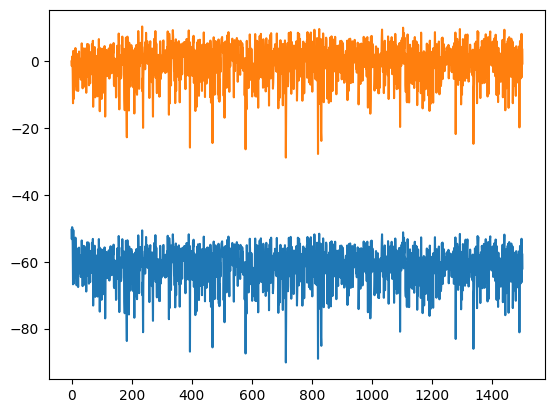

In [86]:
window_size = 1024 * 5
SFT = ShortTimeFFT(win=np.ones(window_size), hop=window_size, fs=fs, fft_mode="centered")
D = SFT.stft(d)
PSD = np.abs(D)**2
P = db(PSD)
baseline = np.cumsum(P, axis=1) / np.arange(1, P.shape[1] + 1)
P_adj = P - baseline

plt.plot(P[1])
plt.plot(P_adj[1])

""" plt.figure(figsize=(20,8))
plt.imshow(P, aspect='auto', extent=(f[0], f[-1], T[0], T[-1]))
plt.colorbar(label="dB")
plt.ylabel("time/s")
plt.xlabel("freq/MHz") """


In [18]:
%%time
# perform FFT over sliding window, and convert to dB
window_size = 1024 * 5
SFT = ShortTimeFFT(win=np.ones(window_size), hop=window_size, fs=fs, fft_mode="centered")
D = SFT.stft(samples)
PSD = np.abs(D)**2
P = db(PSD)
# we can try slightly different ways to compute and subtract the noise floor
# baseline = np.mean(P, axis=0, keepdims=True)
# baseline = ndimage.uniform_filter1d(P, size=100_000, axis=1, mode="constant", cval=0)
baseline = np.cumsum(P, axis=1) / np.arange(1, P.shape[1] + 1)
P_adj = P - baseline


[[-69.9329317  -69.5726907  -67.3770961  ... -61.99176785 -61.90896281
  -62.01965177]
 [-66.06723252 -65.61322594 -62.41214718 ... -62.35838943 -62.23518207
  -62.40640441]
 [-65.49601454 -65.0912659  -66.65147396 ... -60.53461668 -60.66803751
  -60.73467782]
 ...
 [-62.2026692  -60.1620542  -59.14518766 ... -62.27560531 -62.06537538
  -62.1096044 ]
 [-61.70602341 -61.00869146 -59.36276855 ... -60.84242372 -60.88425856
  -60.90278639]
 [-60.90440148 -70.4799487  -68.17723545 ... -60.97806862 -61.01043847
  -61.03030933]]
CPU times: total: 46.9 ms
Wall time: 55.8 ms


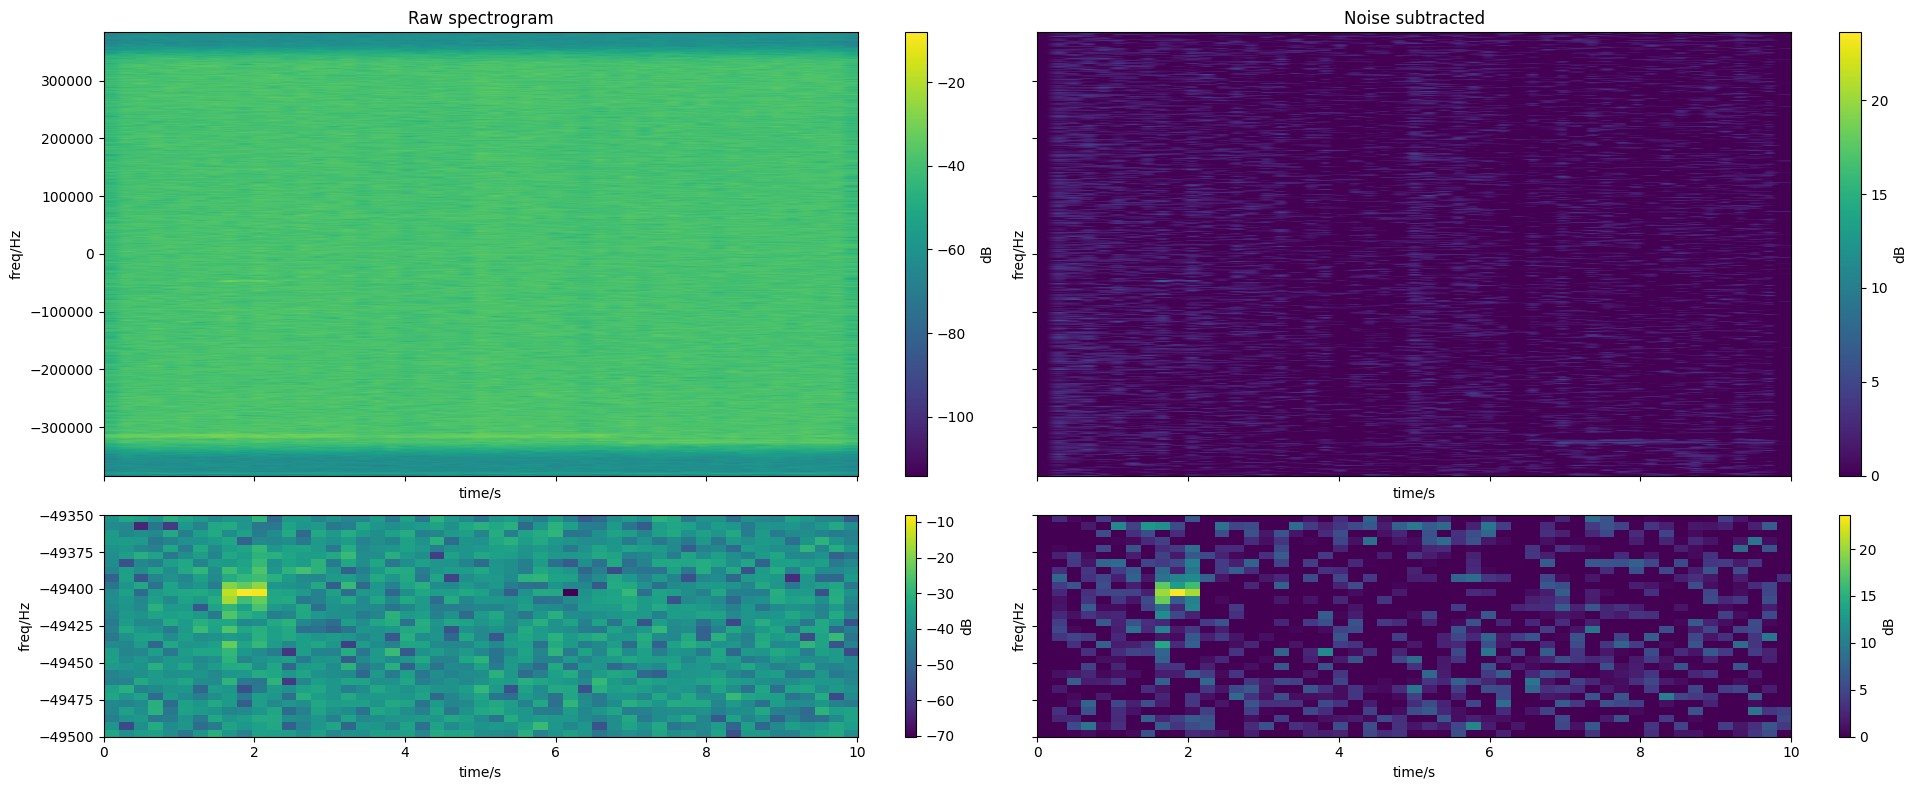

In [16]:
extent_full = t0, t1, f0, f1 = SFT.extent(len(d))
_slice = slice(2230, 2260)
f_slice = np.linspace(f0, f1, num=P.shape[0])
f2, f3 = f_slice[_slice][0], f_slice[_slice][1]
extent_slice = (t0, t1, f2, f3)
fig, axes = plt.subplots(figsize=(20, 8), nrows=2, ncols=2, sharex=True, sharey="row", height_ratios=[2,1])
ax = axes[0][0]
im = ax.imshow(
    P,
    aspect="auto",
    origin="lower",
    extent=extent_full,
)
fig.colorbar(im, label="dB", ax=ax)
ax.set_xlabel("time/s")
ax.set_ylabel("freq/Hz")
ax.set_title("Raw spectrogram")

ax = axes[0][1]
im = ax.imshow(
    P_adj,
    aspect="auto",
    origin="lower",
    extent=SFT.extent(len(d)),
    vmin=0,
)
fig.colorbar(im, label="dB", ax=ax)
ax.set_xlabel("time/s")
ax.set_ylabel("freq/Hz")
ax.set_title("Noise subtracted")
plt.tight_layout()

ax = axes[1][0]
im = ax.imshow(P[_slice], aspect="auto", origin="lower", extent=extent_slice)
fig.colorbar(im, label="dB", ax=ax)
ax.set_xlabel("time/s")
ax.set_ylabel("freq/Hz")

ax = axes[1][1]
im = ax.imshow(
    P_adj[_slice],
    aspect="auto",
    origin="lower",
    vmin=0,
    extent=extent_slice
)
fig.colorbar(im, label="dB", ax=ax)
ax.set_xlabel("time/s")
ax.set_ylabel("freq/Hz")
plt.tight_layout()

In [22]:
print(np.shape(P_adj))
print(P_adj)

(5120, 51)
[[ 0.          0.360241    4.3911892  ...  9.56465286  4.05744689
  -5.53444804]
 [ 0.          0.45400658  6.40215751 ...  4.15083782  6.0371609
  -8.5611169 ]
 [ 0.          0.40474864 -3.12041612 ...  5.22141063 -6.53762091
  -3.33201571]
 ...
 [ 0.          2.040615    2.03373306 ...  0.97851985 10.30126656
  -2.21145125]
 [ 0.          0.69733195  3.29184583 ...  6.8430644  -2.04990702
  -0.92639177]
 [ 0.         -9.57554722  4.6054265  ... -1.85246425 -1.58612293
  -0.99354283]]
